# Build station features and exploratory analysis

This notebook processes minute-level GTFS-realtime snapshots, 
builds station-level features and explores the resulting dataset.

In [1]:
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz

from metro_disruptions_intelligence.features import SnapshotFeatureBuilder
from metro_disruptions_intelligence.processed_reader import load_rt_dataset

In [2]:
project_root = Path.cwd()
if not (project_root / "notebooks").exists():
    project_root = project_root.parent

processed_rt = project_root / "data" / "processed_final" / "rt"
features_root = project_root / "data" / "stations_features_time_series"
features_root.mkdir(parents=True, exist_ok=True)

In [3]:
processed_rt, features_root

(WindowsPath('c:/Users/Luis.ParraMorales/GitProjects/metro_disruptions_intelligence/data/processed_final/rt'),
 WindowsPath('c:/Users/Luis.ParraMorales/GitProjects/metro_disruptions_intelligence/data/stations_features_time_series'))

## Available routes

In [ ]:
trip_ds = load_rt_dataset(processed_rt, feeds=["trip_updates"])
unique_routes = trip_ds["route_id"].unique()
print("Routes found:", unique_routes)

## Helper functions

In [4]:
def discover_all_snapshot_minutes(root: Path) -> list[int]:
    """Return all snapshot minutes from trip update files."""
    files = sorted((root / "trip_updates").rglob("trip_updates_*.parquet"))
    minutes = []
    for f in files:
        ts_part = f.stem.split("trip_updates_")[-1]
        try:
            dt = datetime.strptime(ts_part, "%Y-%d-%m-%H-%M").replace(tzinfo=pytz.UTC)
        except ValueError:
            continue
        minutes.append(int(dt.timestamp()))
    return sorted(minutes)


def compose_path(ts: int, root: Path, feed: str) -> Path:
    """Construct path for a feed timestamp."""
    dt = datetime.fromtimestamp(ts, tz=pytz.UTC)
    fname = f"{feed}_{dt:%Y-%d-%m-%H-%M}.parquet"
    return (
        root / feed / f"year={dt.year:04d}" / f"month={dt.month:02d}" / f"day={dt.day:02d}" / fname
    )


def build_route_map(root: Path) -> dict:
    """Return route-to-stop mapping from first snapshot."""
    first = sorted((root / "trip_updates").rglob("*.parquet"))[0]
    df = pd.read_parquet(first)
    tu = df[["route_id", "direction_id", "stop_id", "stop_sequence"]].drop_duplicates()
    tu = tu.sort_values(["route_id", "direction_id", "stop_sequence"])
    return tu.groupby(["route_id", "direction_id"])["stop_id"].apply(list).to_dict()

## Generate features

In [5]:
minutes = discover_all_snapshot_minutes(processed_rt)
route_map = build_route_map(processed_rt)
builder = SnapshotFeatureBuilder(route_map)

for ts in minutes:
    tu_file = compose_path(ts, processed_rt, "trip_updates")
    vp_file = compose_path(ts, processed_rt, "vehicle_positions")
    if not tu_file.exists() or not vp_file.exists():
        continue
    trip_now = pd.read_parquet(tu_file)
    veh_now = pd.read_parquet(vp_file)
    feats = builder.build_snapshot_features(trip_now, veh_now, ts)
    if feats.empty:
        continue
    feats = feats.reset_index()
    feats["snapshot_timestamp"] = ts
    dt = datetime.fromtimestamp(ts, tz=pytz.UTC)
    out_dir = features_root / f"year={dt.year:04d}" / f"month={dt.month:02d}" / f"day={dt.day:02d}"
    out_dir.mkdir(parents=True, exist_ok=True)
    out_file = out_dir / f"stations_feats_{dt:%Y-%d-%m-%H-%M}.parquet"
    feats.to_parquet(out_file, compression="snappy", index=False)

## Load generated features

In [6]:
print(features_root)

c:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence\data\stations_features_time_series


In [7]:
feature_files = sorted(features_root.rglob("stations_feats_*.parquet"))
feats_all = pd.concat([pd.read_parquet(f) for f in feature_files], ignore_index=True)
feats_all["snapshot_timestamp"] = pd.to_datetime(
    feats_all["snapshot_timestamp"], unit="s", utc=True
).dt.tz_convert("Australia/Sydney")
feats_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4324151 entries, 0 to 4324150
Data columns (total 25 columns):
 #   Column                  Dtype                           
---  ------                  -----                           
 0   stop_id                 object                          
 1   direction_id            int64                           
 2   arrival_delay_t         float64                         
 3   departure_delay_t       float64                         
 4   headway_t               float64                         
 5   rel_headway_t           float64                         
 6   dwell_delta_t           float64                         
 7   delay_arrival_grad_t    float64                         
 8   delay_departure_grad_t  float64                         
 9   upstream_delay_mean_2   float64                         
 10  downstream_delay_max_2  float64                         
 11  delay_mean_5            float64                         
 12  delay_std_5   

In [8]:
feats_all.isna().mean()

stop_id                   0.000000
direction_id              0.000000
arrival_delay_t           0.957408
departure_delay_t         0.959743
headway_t                 0.958455
rel_headway_t             0.958455
dwell_delta_t             0.959743
delay_arrival_grad_t      0.957408
delay_departure_grad_t    0.959743
upstream_delay_mean_2     0.979501
downstream_delay_max_2    0.979920
delay_mean_5              0.957697
delay_std_5               0.957697
delay_mean_15             0.958239
headway_p90_60            0.957537
sin_hour                  0.000000
cos_hour                  0.000000
day_type                  0.000000
node_degree               0.000000
hub_flag                  0.000000
is_train_present          0.000000
data_fresh_secs           0.957408
local_dt                  0.000000
snapshot_timestamp        0.000000
index                     0.290252
dtype: float64

In [9]:
describe = feats_all.describe()

In [10]:
describe

,direction_id,arrival_delay_t,departure_delay_t,headway_t,rel_headway_t,dwell_delta_t,delay_arrival_grad_t,delay_departure_grad_t,upstream_delay_mean_2,downstream_delay_max_2,...,delay_mean_15,headway_p90_60,sin_hour,cos_hour,day_type,node_degree,hub_flag,is_train_present,data_fresh_secs,index
count,4.324151e+06,184174.000000,174078.000000,179649.000000,179649.000000,174078.000000,184174.000000,174077.000000,88642.000000,86828.000000,...,180579.000000,183617.000000,4.324151e+06,4.324151e+06,4.324151e+06,4.324151e+06,4.324151e+06,4.324151e+06,184174.000000,3.069059e+06
mean,5.076277e-01,9.391407,9.249314,368.519430,0.931110,0.010668,0.013357,0.012696,5.162458,5.029956,...,9.524281,461.300407,-9.245601e-02,-4.056251e-02,3.051683e-01,9.407775e-01,4.484052e-01,2.917382e-02,3043.973731,2.297656e+01
std,4.999419e-01,36.484605,36.241470,172.110904,2.191611,2.024836,47.396670,46.956943,13.918581,17.769614,...,23.180179,163.210139,7.071756e-01,6.997924e-01,4.604787e-01,9.759743e-01,4.973309e-01,1.682935e-01,12613.128772,1.355398e+01
min,0.000000e+00,-300.000000,-300.000000,1.000000,-252.571429,-234.000000,-340.000000,-336.000000,-209.500000,-234.000000,...,-87.533333,56.000000,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,0.000000e+00,0.000000,0.000000,240.000000,0.983333,0.000000,-4.000000,-4.000000,0.000000,-1.000000,...,0.000000,303.400000,-7.071068e-01,-7.071068e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000,1.100000e+01
50%,1.000000e+00,0.000000,0.000000,296.000000,1.000000,0.000000,0.000000,0.000000,1.500000,0.000000,...,3.666667,597.400000,-2.588190e-01,-1.836970e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000,2.300000e+01
75%,1.000000e+00,17.000000,17.000000,597.000000,1.010000,0.000000,4.000000,4.000000,12.000000,17.000000,...,12.533333,604.400000,7.071068e-01,7.071068e-01,1.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,305.000000,3.500000e+01
max,1.000000e+00,300.000000,300.000000,3000.000000,32.000000,390.000000,357.000000,353.000000,300.000000,728.000000,...,182.666667,2400.000000,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,86400.000000,4.600000e+01


In [11]:
describe.to_csv(r'C:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence\data\working_data\describe_features.csv',index=False)

## Plot headways and delays

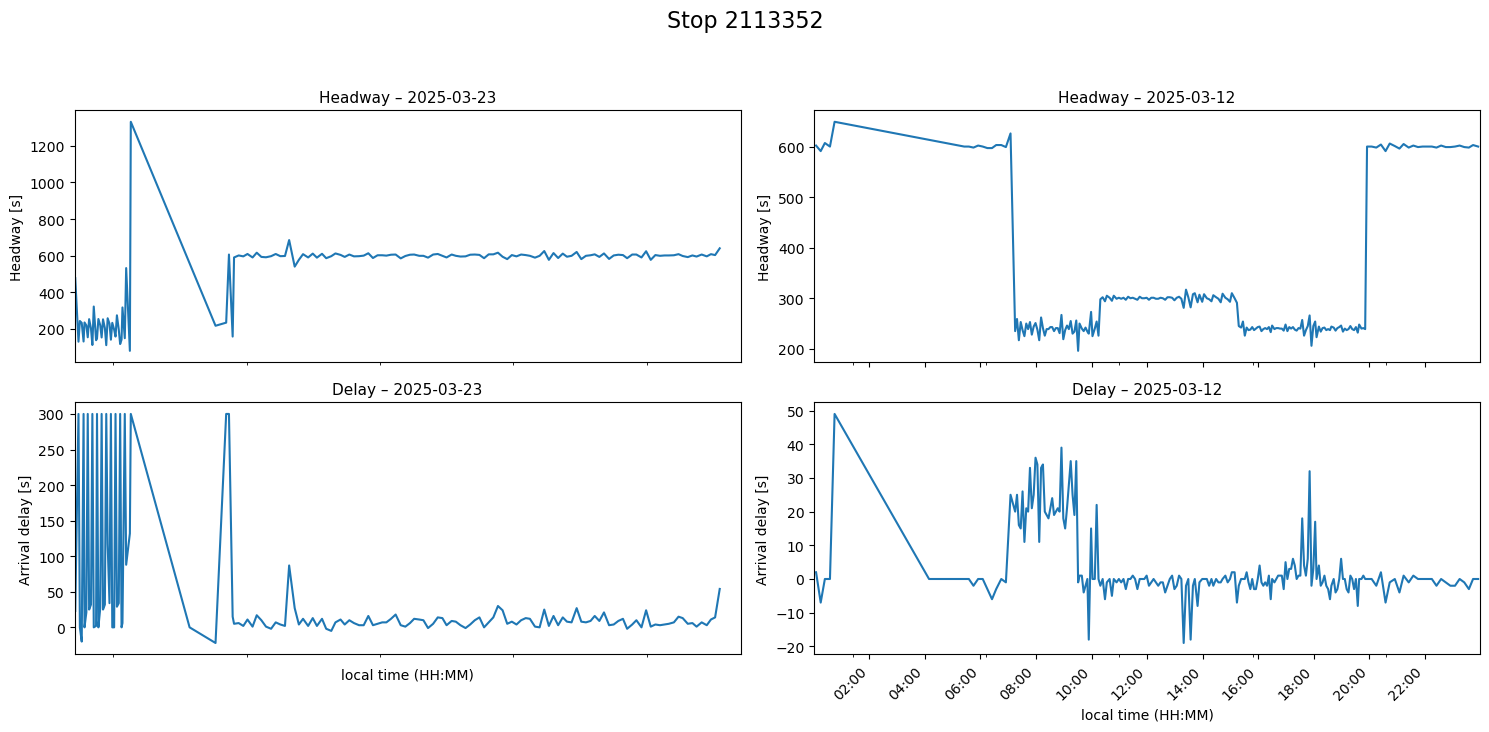

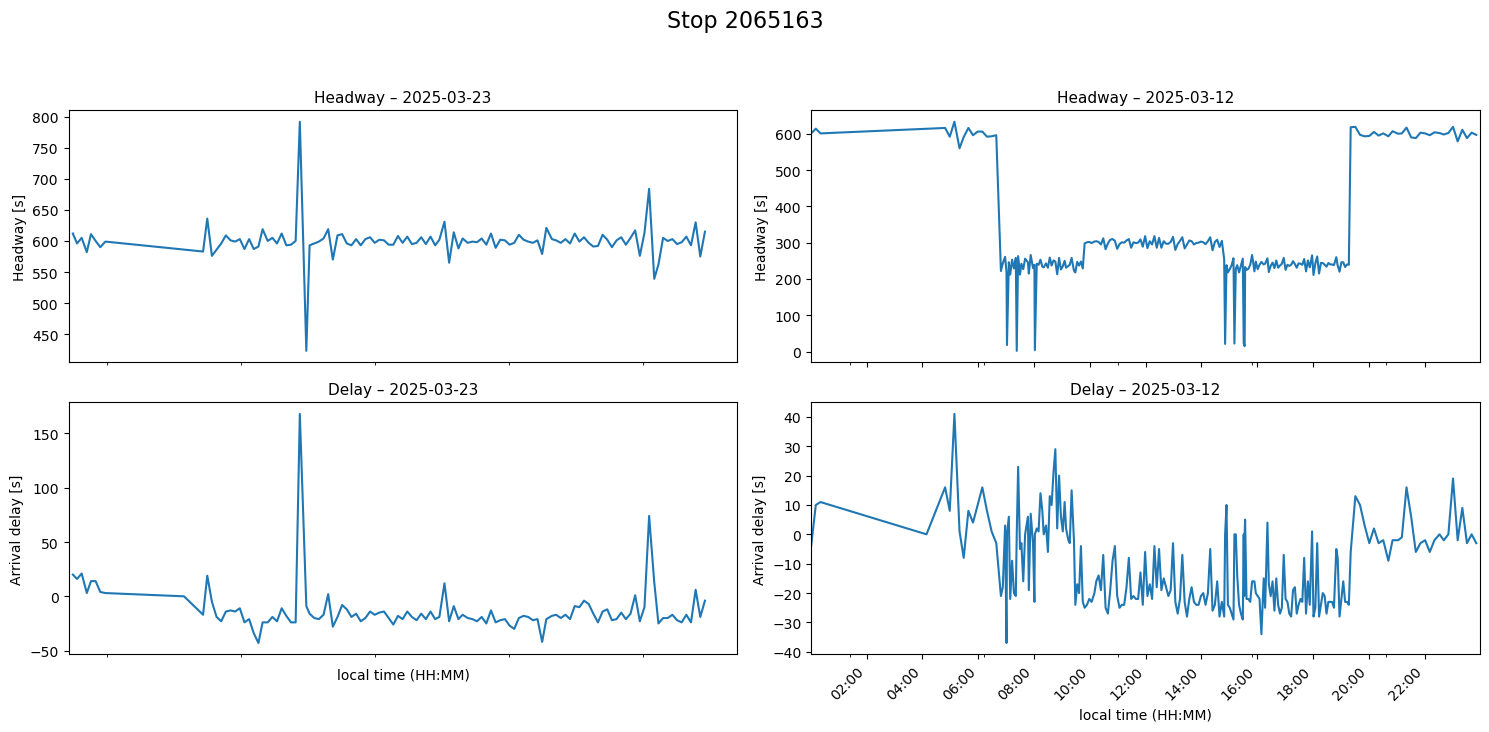

In [22]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, HourLocator
import pytz, datetime as dt

# ------------------------------------------------------------------
# 0  Convert epoch → Sydney-local once
# ------------------------------------------------------------------
tz_syd = pytz.timezone("Australia/Sydney")
feats_all["local_dt"] = (
    pd.to_datetime(feats_all["snapshot_timestamp"], unit="s", utc=True)
      .dt.tz_convert(tz_syd)
)

# ------------------------------------------------------------------
# 1  Random sample
# ------------------------------------------------------------------
days  = np.random.choice(feats_all["local_dt"].dt.date.unique(), 2, replace=False)
stops = np.random.choice(feats_all["stop_id"].unique(),               2, replace=False)

# tick helpers
fmt    = DateFormatter("%H:%M", tz=tz_syd)
hourly = HourLocator(byhour=range(0, 24, 2), tz=tz_syd)

for stop in stops:
    fig, axes = plt.subplots(2, 2, figsize=(15, 7), sharex="col")
    fig.suptitle(f"Stop {stop}", fontsize=16, y=1.04)

    for col, day in enumerate(days):
        start = tz_syd.localize(dt.datetime.combine(day, dt.time(0, 1)))
        end   = tz_syd.localize(dt.datetime.combine(day, dt.time(23, 59)))
        mask  = (
            (feats_all["stop_id"] == stop) &
            (feats_all["local_dt"] >= start) &
            (feats_all["local_dt"] <= end)
        )
        sub = feats_all.loc[mask]

        # ------------------------------------------------------------------
        # HEADWAY
        # ------------------------------------------------------------------
        ax_h = axes[0, col]
        (sub[["local_dt", "headway_t"]]
           .dropna()
           .plot(x="local_dt", y="headway_t", ax=ax_h, legend=False))
        ax_h.set_title(f"Headway – {day.isoformat()}", fontsize=11)
        ax_h.set_xlim(start, end)
        ax_h.xaxis.set_major_locator(hourly)
        ax_h.xaxis.set_major_formatter(fmt)
        ax_h.tick_params(axis="x", rotation=45)
        ax_h.set_xlabel("local time (HH:MM)")
        ax_h.set_ylabel("Headway [s]")

        # ------------------------------------------------------------------
        # ARRIVAL DELAY
        # ------------------------------------------------------------------
        ax_d = axes[1, col]
        (sub[["local_dt", "arrival_delay_t"]]
           .dropna()
           .plot(x="local_dt", y="arrival_delay_t", ax=ax_d, legend=False))
        ax_d.set_title(f"Delay – {day.isoformat()}",   fontsize=11)
        ax_d.set_xlim(start, end)
        ax_d.xaxis.set_major_locator(hourly)
        ax_d.xaxis.set_major_formatter(fmt)
        ax_d.tick_params(axis="x", rotation=45)
        ax_d.set_xlabel("local time (HH:MM)")
        ax_d.set_ylabel("Arrival delay [s]")

    fig.tight_layout()
    plt.show()


Quick checks

0 zero headways between 05-23h
                      local_dt  headway_t        snapshot_timestamp
763  2025-03-07 04:27:00+11:00      623.0 2025-03-07 04:27:00+11:00
966  2025-03-07 04:32:00+11:00      626.0 2025-03-07 04:32:00+11:00
1126 2025-03-07 04:36:00+11:00      605.0 2025-03-07 04:36:00+11:00
1206 2025-03-07 04:38:00+11:00      628.0 2025-03-07 04:38:00+11:00
1536 2025-03-07 04:46:00+11:00      616.0 2025-03-07 04:46:00+11:00


Text(0.5, 1.0, 'Arrival-delay distribution')

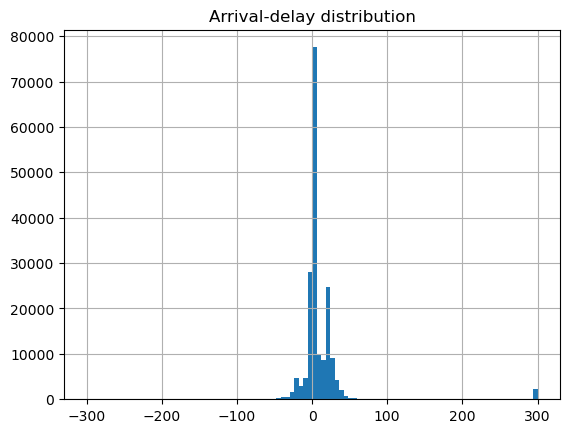

In [20]:
# 1. How many zeros during revenue hours?
mask_service = feats_all["local_dt"].dt.hour.between(5, 23)
zero_hdw = feats_all[mask_service & (feats_all["headway_t"] == 0)]
print(len(zero_hdw), "zero headways between 05-23h")

# 2. TU latency behind those >10-min gaps
suspect = feats_all[feats_all["headway_t"] > 10*60]
print(suspect[["local_dt", "headway_t", "snapshot_timestamp"]].head())

# 3. Distribution of arrival_delay_t
feats_all["arrival_delay_t"].hist(bins=100); plt.title("Arrival-delay distribution")


Text(0.5, 1.0, 'Headway distribution')

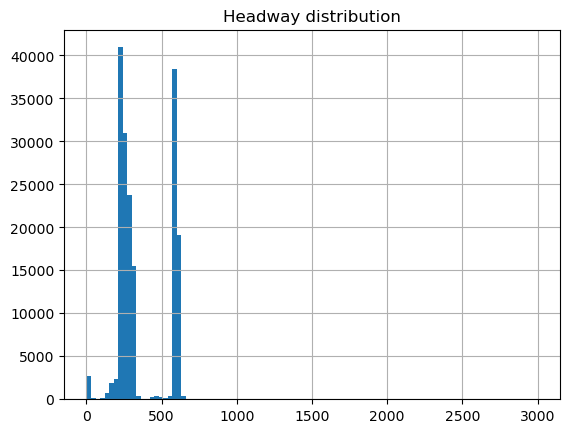

In [21]:
# 4. Distribution of arrival_delay_t
feats_all["headway_t"].hist(bins=100); plt.title("Headway distribution")

### Plots for one station

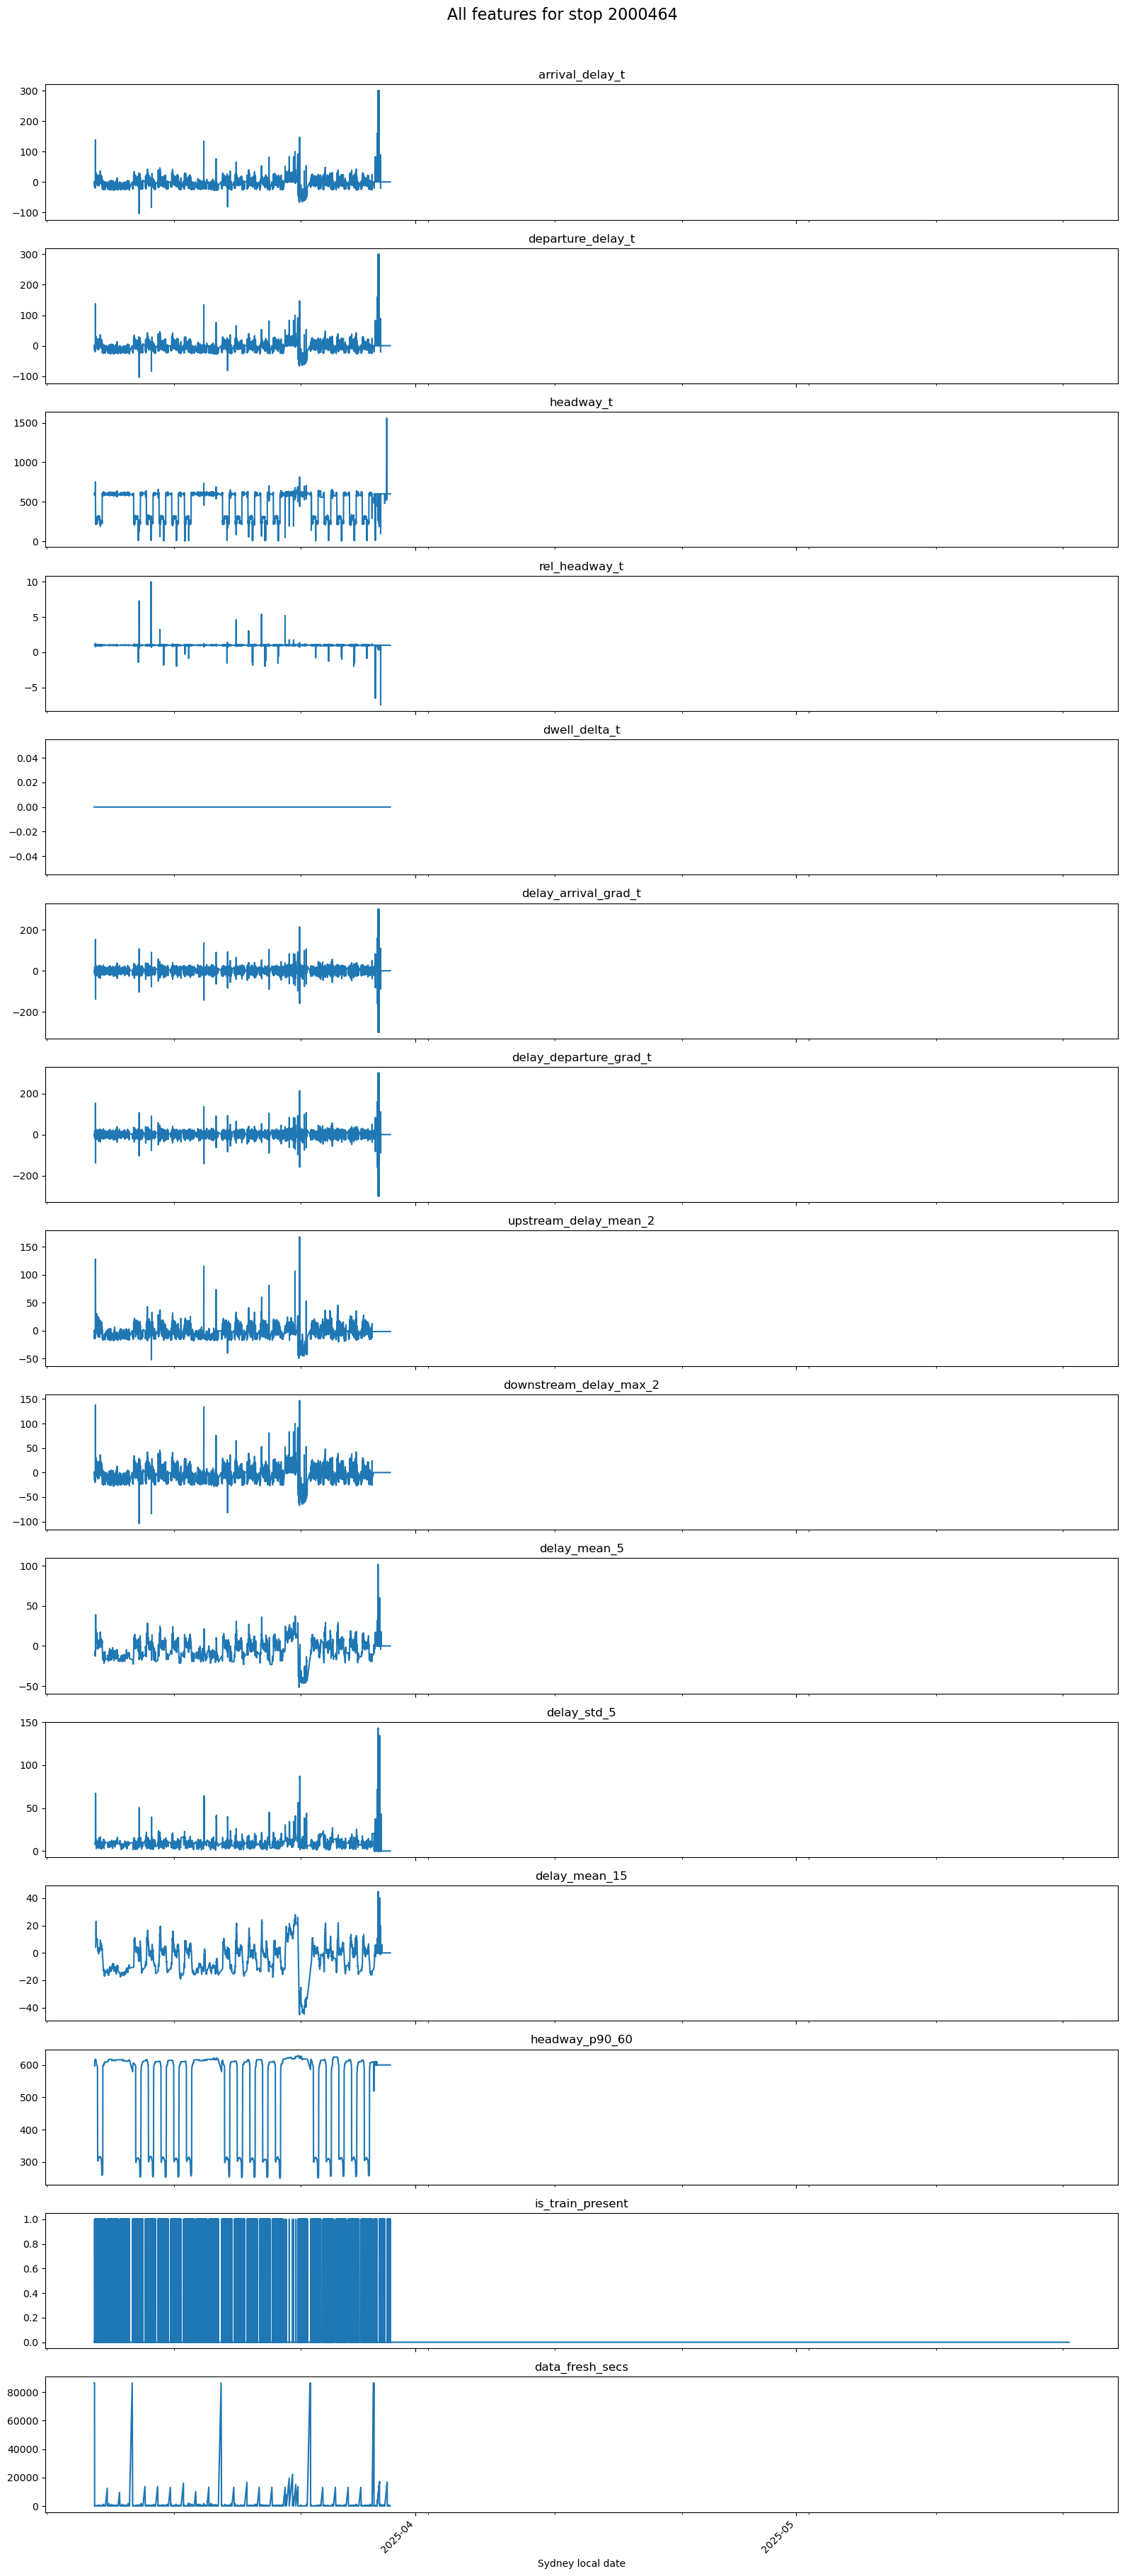

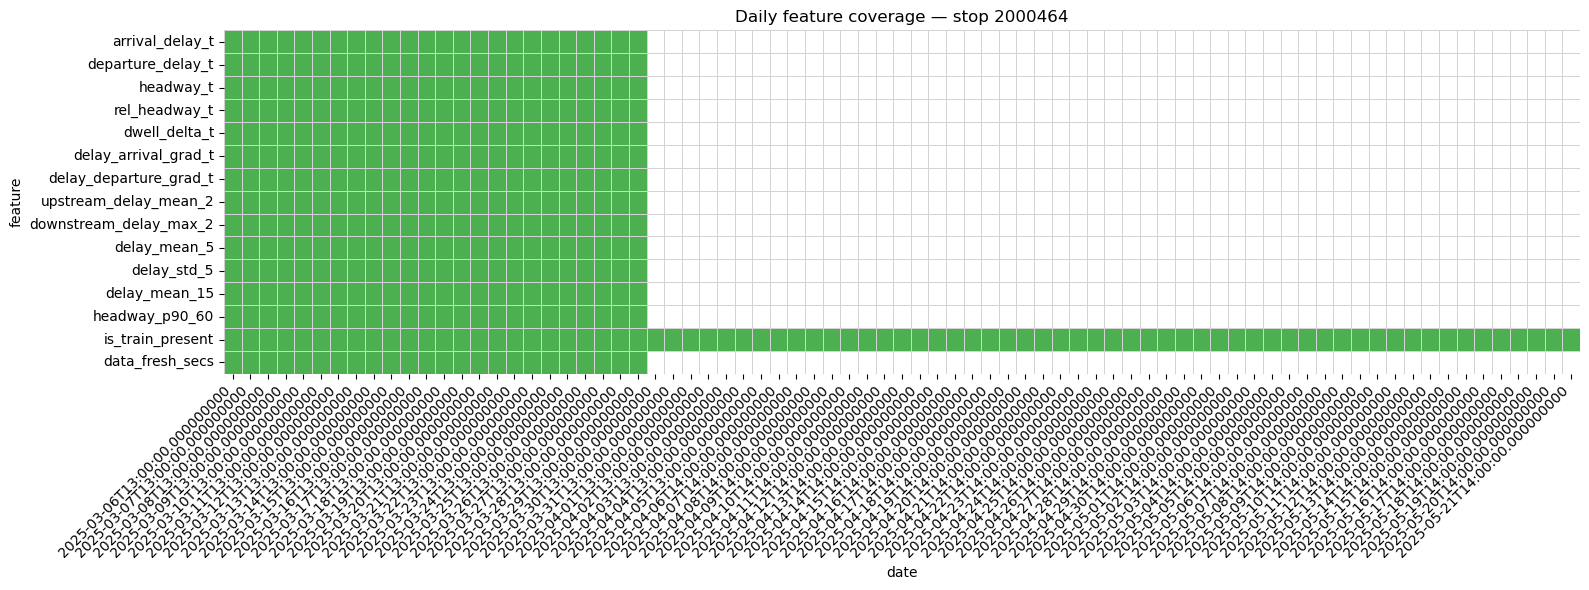


Days with *no* data at stop 2000464: None 🎉


In [28]:
import seaborn as sns
from matplotlib.dates import DateFormatter, MonthLocator
from pandas.api.types import is_datetime64_any_dtype   # << fix for dtype test
import pytz, datetime as dt

station_id = 2000464          # <<< station you want to inspect

# ────────────────────────────────────────────────────────────────────────────
# 0.  Reliable sub-set (cast stop_id -> int so we match numeric literal)
# ────────────────────────────────────────────────────────────────────────────
sub = feats_all[feats_all["stop_id"].astype(int) == int(station_id)].copy()

if sub.empty:
    raise ValueError(f"No rows found for stop_id {station_id}")

# ────────────────────────────────────────────────────────────────────────────
# 1.  Ensure local_dt exists and is timezone-aware (Australia/Sydney)
# ────────────────────────────────────────────────────────────────────────────
if "local_dt" not in sub.columns or not is_datetime64_any_dtype(sub["local_dt"]):
    tz_syd = pytz.timezone("Australia/Sydney")
    sub["local_dt"] = (
        pd.to_datetime(sub["snapshot_timestamp"], unit="s", utc=True)
          .dt.tz_convert(tz_syd)
    )

# ────────────────────────────────────────────────────────────────────────────
# 2.  Time-series panel — one subplot per feature
# ────────────────────────────────────────────────────────────────────────────
feat_cols = [
    "arrival_delay_t", "departure_delay_t", "headway_t", "rel_headway_t",
    "dwell_delta_t", "delay_arrival_grad_t", "delay_departure_grad_t",
    "upstream_delay_mean_2", "downstream_delay_max_2", "delay_mean_5",
    "delay_std_5", "delay_mean_15", "headway_p90_60",
    "is_train_present", "data_fresh_secs"
]

# keep only features with at least one non-NaN
feat_cols = [c for c in feat_cols if sub[c].notna().any()]
n_feat    = len(feat_cols)

fig, axes = plt.subplots(n_feat, 1, figsize=(16, 2.4 * n_feat), sharex=True)
axes      = np.ravel(axes)

month_loc = MonthLocator(interval=1)
fmt_month = DateFormatter("%Y-%m")

for ax, col in zip(axes, feat_cols):
    sub[["local_dt", col]].dropna().plot(x="local_dt", y=col, ax=ax, legend=False)
    ax.set_title(col)
    ax.xaxis.set_major_locator(month_loc)
    ax.xaxis.set_major_formatter(fmt_month)
    ax.tick_params(axis="x", rotation=45)

axes[-1].set_xlabel("Sydney local date")
fig.suptitle(f"All features for stop {station_id}", y=1.01, fontsize=16)
fig.tight_layout()
plt.show()

# ────────────────────────────────────────────────────────────────────────────
# 3.  Daily coverage heat-map  (1 = at least one non-NaN sample that day)
# ────────────────────────────────────────────────────────────────────────────
coverage = (
    sub.set_index("local_dt")
       .groupby(pd.Grouper(freq="D"))[feat_cols]
       .apply(lambda d: d.notna().any())
       .astype(int)
)

plt.figure(figsize=(16, 6))
sns.heatmap(coverage.T, cmap=["white", "#4caf50"], cbar=False,
            linewidths=.5, linecolor="lightgrey")
plt.title(f"Daily feature coverage — stop {station_id}")
plt.ylabel("feature"); plt.xlabel("date")
plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ────────────────────────────────────────────────────────────────────────────
# 4.  List calendar days that are totally empty
# ────────────────────────────────────────────────────────────────────────────
empty_days = coverage.index[coverage.sum(axis=1) == 0]
print(f"\nDays with *no* data at stop {station_id}:",
      empty_days.date.tolist() if len(empty_days) else "None 🎉")


### Plots for all station

In [29]:
from matplotlib.dates import DateFormatter, MonthLocator
from pandas.api.types import is_datetime64_any_dtype
from matplotlib.backends.backend_pdf import PdfPages
import pytz

# ─── configuration ──────────────────────────────────────────────────────────
OUT_PDF      = "station_feature_plots.pdf"
PLOT_FEATURES = [
    "arrival_delay_t", "departure_delay_t", "headway_t", "rel_headway_t",
    "dwell_delta_t", "delay_arrival_grad_t", "delay_departure_grad_t",
    "upstream_delay_mean_2", "downstream_delay_max_2", "delay_mean_5",
    "delay_std_5", "delay_mean_15", "headway_p90_60",
    "is_train_present", "data_fresh_secs"
]
tz_syd = pytz.timezone("Australia/Sydney")

# ─── make sure local_dt exists globally (avoids repeating in loop) ──────────
if "local_dt" not in feats_all.columns or not is_datetime64_any_dtype(feats_all["local_dt"]):
    feats_all["local_dt"] = (
        pd.to_datetime(feats_all["snapshot_timestamp"], unit="s", utc=True)
          .dt.tz_convert(tz_syd)
    )

# ─── iterate over stations and export to a single PDF ───────────────────────
with PdfPages(OUT_PDF) as pdf:
    for sid in sorted(feats_all["stop_id"].astype(int).unique()):
        sub = feats_all[feats_all["stop_id"].astype(int) == sid].copy()
        if sub.empty:
            continue

        # choose only features that have at least one real value
        feat_cols = [c for c in PLOT_FEATURES if sub[c].notna().any()]
        n_feat    = len(feat_cols)

        # ── 1. feature panel ────────────────────────────────────────────────
        fig, axes = plt.subplots(n_feat, 1,
                                 figsize=(16, 2.2 * n_feat), sharex=True)
        axes = np.ravel(axes)
        month_loc = MonthLocator(interval=1)
        fmt_month = DateFormatter("%Y-%m")

        for ax, col in zip(axes, feat_cols):
            sub[["local_dt", col]].dropna().plot(x="local_dt", y=col,
                                                ax=ax, legend=False)
            ax.set_title(col)
            ax.xaxis.set_major_locator(month_loc)
            ax.xaxis.set_major_formatter(fmt_month)
            ax.tick_params(axis="x", rotation=45)

        axes[-1].set_xlabel("Sydney local date")
        fig.suptitle(f"All features — stop {sid}", y=1.02, fontsize=16)
        fig.tight_layout(rect=[0, 0, 1, 0.98])

        # ── 2. daily coverage heat-map ──────────────────────────────────────
        coverage = (
            sub.set_index("local_dt")
               .groupby(pd.Grouper(freq="D"))[feat_cols]
               .apply(lambda d: d.notna().any())
               .astype(int)
        )
        fig2, ax2 = plt.subplots(figsize=(16, 5))
        sns.heatmap(coverage.T, cmap=["white", "#4caf50"], cbar=False,
                    linewidths=.5, linecolor="lightgrey", ax=ax2)
        ax2.set_title(f"Daily feature coverage — stop {sid}")
        ax2.set_ylabel("feature");   ax2.set_xlabel("date")
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
        ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)
        fig2.tight_layout()

        # — save both pages —
        pdf.savefig(fig);  plt.close(fig)
        pdf.savefig(fig2); plt.close(fig2)

print(f"✅ Finished.  Plots saved to {OUT_PDF}")


✅ Finished.  Plots saved to station_feature_plots.pdf


## Sydney Metro M Line
The `SMNW_M1` route-id corresponds to the Sydney Metro line currently running Tallawong ⇄ Chatswood.

In [14]:
import folium
import pandas as pd

gtfs_root = project_root / "sample_data" / "static"
routes = pd.read_csv(gtfs_root / "routes.txt")
stops = pd.read_csv(gtfs_root / "stops.txt")
trips = pd.read_csv(gtfs_root / "trips.txt")
stop_times = pd.read_csv(gtfs_root / "stop_times.txt")
shapes = pd.read_csv(gtfs_root / "shapes.txt")

m_route = routes[routes["route_id"] == "SMNW_M1"]
display(m_route)
m_trip = trips[trips["route_id"] == "SMNW_M1"].iloc[0]
shape_points = shapes[shapes["shape_id"] == m_trip["shape_id"]].sort_values("shape_pt_sequence")
line = list(zip(shape_points["shape_pt_lat"], shape_points["shape_pt_lon"]))
stop_ids = stop_times[stop_times["trip_id"] == m_trip["trip_id"]]["stop_id"].unique()
stops_subset = stops[stops["stop_id"].isin(stop_ids)]

m = folium.Map(location=[-33.8, 151.1], zoom_start=11)
folium.PolyLine(line, color="blue", weight=5, opacity=0.7).add_to(m)
for _, row in stops_subset.iterrows():
    folium.Marker([row.stop_lat, row.stop_lon], popup=f"{row.stop_name} ({row.stop_id})").add_to(m)
m

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_color,route_text_color,route_url
0,SMNW_M1,SMNW,M1,Metro North West & Bankstown Line,Sydney Metro Network,401,168388,FFFFFF,NaN
